In [1]:
import os, sys, pickle
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from common.evaluate import make_vis_env, test_env
from results_path import DDPG_PATH, PPO_PATH

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
AGENT = 'PPO'

In [2]:
ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-20_05-55-33_60839/logs.
Waiting for redis server at 127.0.0.1:24428 to respond...
Waiting for redis server at 127.0.0.1:46345 to respond...
Starting the Plasma object store with 20.0 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_addresses': ['/tmp/ray/session_2019-04-20_05-55-33_60839/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-20_05-55-33_60839/sockets/raylet'],
 'redis_address': '10.138.0.2:24428',
 'webui_url': ''}

In [3]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

create_env, env_name = make_create_env(params=flow_params, version=0)

In [4]:
# Register as rllib env
register_env(env_name, create_env)

In [5]:
checkpoint = '500'

In [6]:
config_path = '/headless/rl_project/ray_results/multi_merge/' + DDPG_PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/multi_merge/' + DDPG_PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

In [7]:
with open(config_path, mode='rb') as f:
    config = pickle.load(f)

In [8]:
agent = DDPGAgent(config=config, env=env_name)

Created LogSyncer for /headless/ray_results/DDPG_MultiWaveAttenuationMergePOEnv-v0_2019-04-20_05-55-33yg3_vc8g -> None
 Starting SUMO on port 54123
2019-04-20 05:55:34,963	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)


VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.
 Starting SUMO on port 54123


In [9]:
agent.restore(checkpoint_path)

In [10]:
# env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
env = create_env()

 Starting SUMO on port 45189


In [14]:
for i in range(5):
    vel = []
    state = env.reset()
    for _ in range(env.env_params.horizon):
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        if v < 0:  # if there is car teleportation
            v = vel[-1]
        vel.append(v)
        ids = env.k.vehicle.get_controlled_ids()
        actions = {}
        for id_ in ids:
            action = agent.compute_action(state[id_])
            actions.update({id_: action})
        state, r, _, _ = env.step(actions)
    print(np.mean(vel))
    if i == 0:
        vels = np.array(vel)
    else:
        vels = np.vstack((vels, np.array(vel)))

 Starting SUMO on port 45189
 Starting SUMO on port 45189


19.35335730667154


 Starting SUMO on port 45189


9.071429871615779


 Starting SUMO on port 45189


9.937454704948813


 Starting SUMO on port 45189


7.928135897993825
8.813699918187877


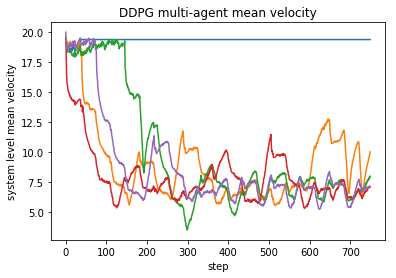

In [15]:
title = 'DDPG multi-agent mean velocity'
savepath = '../result/MultiAgent/' + title.replace(' ', '_') + '.png'

fig = plt.figure()
fig.clf()
plt.title(title)
plt.ylabel('system level mean velocity')
plt.xlabel('step')
for vel in vels:
    plt.plot(vel)

In [13]:
plt.savefig(savepath)

<Figure size 432x288 with 0 Axes>